In [130]:
import nltk
nltk.download('wordnet')
from nltk.corpus import gutenberg, stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup, SoupStrainer
import requests
import lxml
from collections import Counter
from requests import exceptions
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import steam
import pandas as pd
import numpy as np
from rake_nltk import Rake
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from steam.api import interface
steam.api.key.set('FC864146AEF094845C669F86F0B20CFF')
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 80)
%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/sabol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Steam Recommendation Engine #
## Overview ##
As someone somewhere probably said, it's the best time to be playing video games.  Democratization of the tools needed and technical know-how has gotten to the point that almost anyone can sit down and within a matter of 80-100 work weeks over 2-4 years (lol) crank out a game.  But with this over-abundance of choice comes a new problem... UNCERTAINTY. "Do I buy that hot new game that just came out?  What about that other new hot game that came out or that older game that everyone said was great?  Hell, maybe I should just play one of the games I already bought but never installed?”  My aim is to build a recommendation engine that will help people (ME) with this.  Specifically, the engine will not just recommend games available on steam, but will also recommend you games that are already in your library but unplayed.  Yay for saving money!

## Data Collection ##
In order to build the recommendation engine using steam, I used BeautifulSoup to crawl the Steam Store for all games with steam pages. I did this in two steps.  Step 1 was generating a list of links to each game's steam page, starting at page 1 (https://store.steampowered.com/search/?category1=998&page=1).  Once I was able to grab every link, I iterated through each one, grabbing relevant fields such as title, image, description, tags, reviews, etc.

### Grabbing each store link ###

In [ ]:
# Get title and links for all steam games
#urls = ['https://store.steampowered.com/search/?category1=998&page={}'.format(i) for i in range(1, 1185)]

filename = "products_v2.csv"
f = open(filename, "w", encoding="utf-8")
headers = "game_title\tsteam_url\n"
f.write(headers)

for url in urls:
    r = requests.get(url)
    page_soup = soup(r.content, "html.parser")

    containers = page_soup.findAll("a", {"class":"search_result_row ds_collapse_flag "})

    for container in containers:
        game_title = container.findAll("span", {"class":"title"})[0].text
        link = container["href"]

        #print(game_title)
        #print(link)
        #print("----------------")

        f.write(game_title + "\t" + link + "\n")

f.close()

### Iterating through each link, grabing all relevant info from the page###

In [ ]:
#df_links = pd.read_csv('products_v2.csv', delimiter="\t")

tags = []
images = []
descriptions = []
num_reviews = []
rating_values = []
releases = []

cookies = {'birthtime': '568022401'}

for link in df_links.iterrows():
    print(link[1]['game_title'])
    url = link[1]['steam_url']
    r = requests.get(url, cookies=cookies)
    page_soup = soup(r.content, 'lxml')
    try:
        tag = page_soup.find("div", {"class":"glance_tags popular_tags"})
        tag = tag.text
        tag = tag.replace('\t', '').replace('\r', '').replace('\n', ', ').replace('+, ', '').replace(', , ', '')
        tags.append(tag)
    except:
        tag = 'no tags'
        tags.append(tag)
    
    try:
        image = page_soup.find('img', {'class':'game_header_image_full'})['src']
        images.append(image)
    except:
        image = 'no_image'
        images.append(image)
    
    try:
        num_review = int(page_soup.find('meta', {'itemprop':'reviewCount'})['content'])
        num_reviews.append(num_review)
    except:
        num_review = 'no reviews'
        num_reviews.append(num_review)

    try:
        rating_value = float(page_soup.find('meta', {'itemprop':'ratingValue'})['content'])
        rating_values.append(rating_value)
    except:
        rating_value = 'no rating'
        rating_values.append(rating_value)
    
    try:
        description = page_soup.find('div', {'class': 'game_description_snippet'}).text.replace('\t','').replace('\r','').replace('\n', '')
        descriptions.append(description)
    except:
        description = 'no description'
        descriptions.append(description)
        
    try:
        release = page_soup.find('div', {'class': 'date'}).text
        releases.append(release)
    except:
        release = 'no release date'
        releases.append(release)

        
        
    
      
the_rest = pd.DataFrame({'tags': tags, 'image': images, 'description': descriptions,
                         'number_of_review': num_reviews,
                         'score': rating_values,
                         'release_date': releases})

steam_scrape_the_rest = pd.concat([df_links, the_rest], axis=1, sort=False)
steam_scrape_the_rest.to_csv('steam_games_all_fields.csv', sep='\t')

## Data Cleaning and Processing ##

In [36]:
steam_games = pd.read_csv('steam_games_all_fields.csv', index_col=0, delimiter='\t')

# Split out 'appid' from the URL string.  This will be used later to merge in my own games
# from the steam api
app_id = steam_games['steam_url'].str.split('/',expand=True)
app_id = app_id.drop([0, 1, 2, 5, 6], axis=1)
app_id.columns = ['app', 'game_ID']
df = pd.concat([steam_games, app_id], axis=1, sort=False)

# Fill nil values and remove random characters
df['description'] = df['description'].fillna('')
df = df[~df.description.str.contains('no description')]
df['release_date'] = df['release_date'].replace({'no release date' : ''})
df['game_title'] = df['game_title'].str.replace(r'®', '')
df['game_title'] = df['game_title'].str.replace(r'™', '')
df['number_of_review'] = df['number_of_review'].replace({'no reviews' : ''})
df['score'] = df['score'].replace({'no rating' : ''})

# Dropping unneeded/dupe columns and renaming others for merge purposes later
df = df.drop(['app'], axis=1)
df['game_ID'] = pd.to_numeric(df['game_ID'], downcast='signed')
df['number_of_review'] = pd.to_numeric(df['number_of_review'], downcast='integer')
df['score'] = pd.to_numeric(df['score'])

# Game must have a score, scores are not calculated until a min number of reviews is satisfied
df = df[df['score'] > 0]

df = df.rename(columns={"game_ID": "appid"})
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.drop_duplicates(subset='appid', keep='first')
df = df.dropna(subset=['game_title'])
df = df.reset_index()
df = df.drop(['index'], axis=1)
df.shape

(14596, 9)

In [35]:
df_desc = df[['number_of_review', 'score']]
df_desc.describe()

,number_of_review,score
count,"14,596.00000","14,596.00000"
mean,"1,709.28008",7.38113
std,"28,152.31748",1.38787
min,10.00000,2.00000
25%,25.00000,6.00000
50%,76.00000,7.00000
75%,345.00000,9.00000
max,"2,915,091.00000",10.00000


## Data Exploration ##

There are 3,098,835 words in the combination of all descriptions.


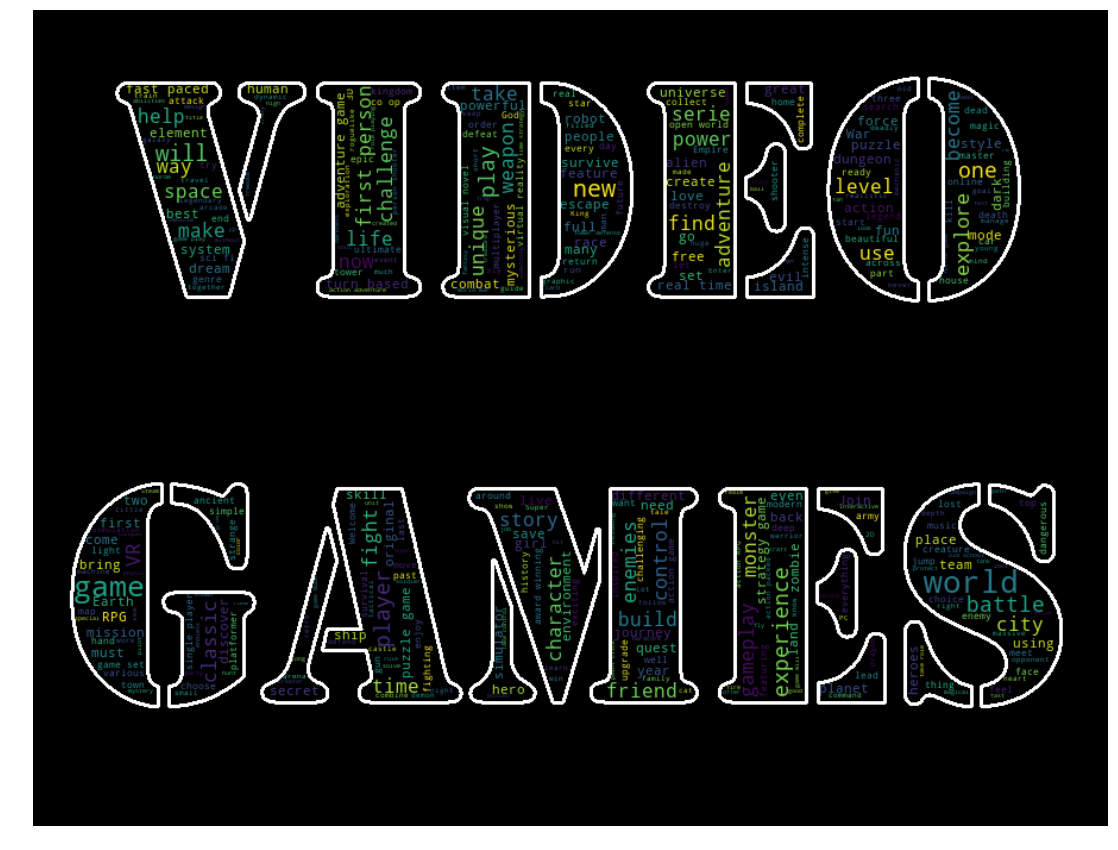

In [33]:
text = " ".join(desc for desc in df.description)
print ("There are {:,.0f} words in the combination of all descriptions.".format(len(text)))
stopwords = set(STOPWORDS)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
video_mask = np.array(Image.open(path.join(d, "video_game_mask.png")))
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=10000,
                      contour_width=3, mask=video_mask, contour_color='white').generate(text)

wc.to_file(path.join(d, 'video_games.png'))

fig, ax = plt.subplots(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

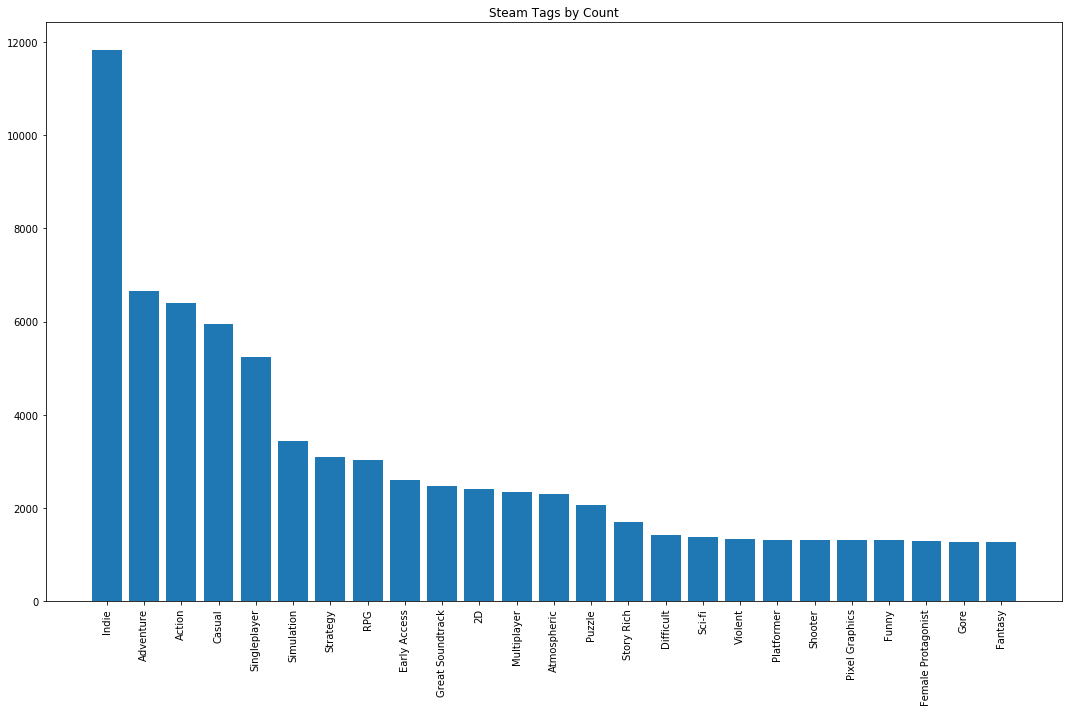

In [4]:
text = " ".join(desc for desc in df.tags)
textlist = text.split(", ")
wordfreq = [textlist.count(w) for w in textlist]
pairs = Counter(text.split(", ")).most_common(25)
word = []
frequency = []

for i in range(len(pairs)):
    word.append(pairs[i][0])
    frequency.append(pairs[i][1])

indices = np.arange(len(pairs))
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(indices, frequency)
plt.title('Steam Tags by Count', )
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


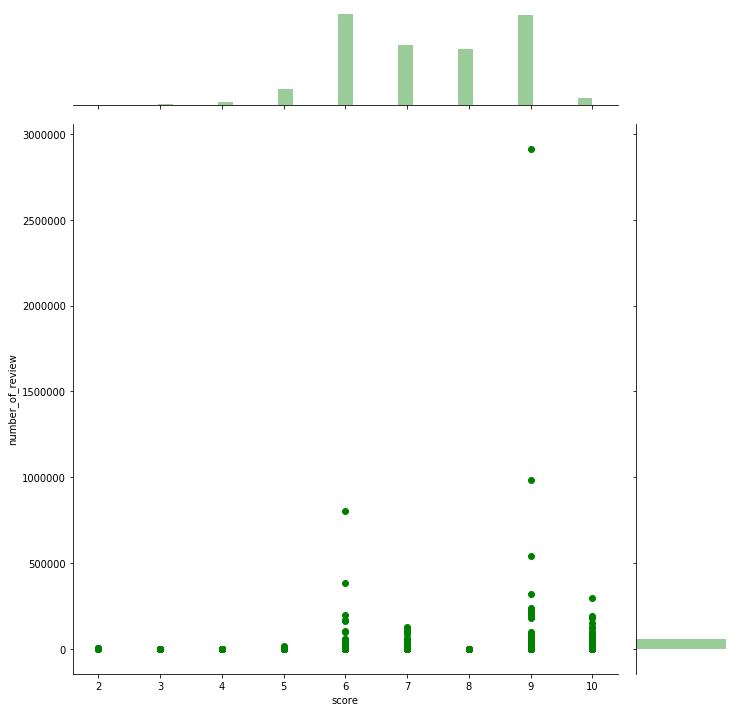

In [37]:

sns.jointplot(x='score', y='number_of_review', data=df, height=10, color='g')
#plt.title('Steam Tags by Count')
#plt.xticks(indices, word, rotation='vertical')
plt.show()

### Using the Steam API to Build My Games DF###
In order to create a recommendation engine that recommends my own games, I needed to find a way to procure my own steam games data.  While I could have also grabbed this data via web scraping, I decided to make use of Steam's API, which allows for easy access into a person's steam games library, provided a user_ID is provided.

In [164]:
my_steam_id = 76561197974553664
games = interface('IPlayerService').GetOwnedGames(steamid=my_steam_id, include_appinfo=1)
my_games = games['response']['games']
game_table = pd.DataFrame(my_games)
game_table = game_table.drop(['has_community_visible_stats', 'playtime_2weeks',
                              'img_icon_url', 'img_logo_url'], axis=1)
# Convert playtime from minutes to hours
game_table['playtime_forever'] = game_table['playtime_forever'] / 60
my_games_info = pd.merge(df, game_table, on='appid')
print('My Games DataFrame Shape:', my_games_info.shape)

my_games_describe = my_games_info[['number_of_review', 'score', 'playtime_forever']]
my_games_describe.describe()

My Games DataFrame Shape: (213, 11)


,number_of_review,score,playtime_forever
count,213.00000,213.00000,213.00000
mean,"39,327.68545",8.64319,9.36557
std,"208,823.54301",1.22644,20.36036
min,180.00000,5.00000,0.00000
25%,"3,998.00000",9.00000,0.01667
50%,"11,035.00000",9.00000,2.46667
75%,"23,045.00000",9.00000,10.01667
max,"2,915,091.00000",10.00000,185.23333


In [52]:
# Create DF of all the steam games that I don't own
not_my_games = pd.merge(df, game_table, how='outer', on='appid')
not_my_games = not_my_games[not_my_games['playtime_forever'].isnull()]
not_my_games = not_my_games.drop(['name', 'image', 'playtime_forever'], axis=1)
print('Dataframe Shape:', not_my_games.shape)

Dataframe Shape: (14383, 8)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


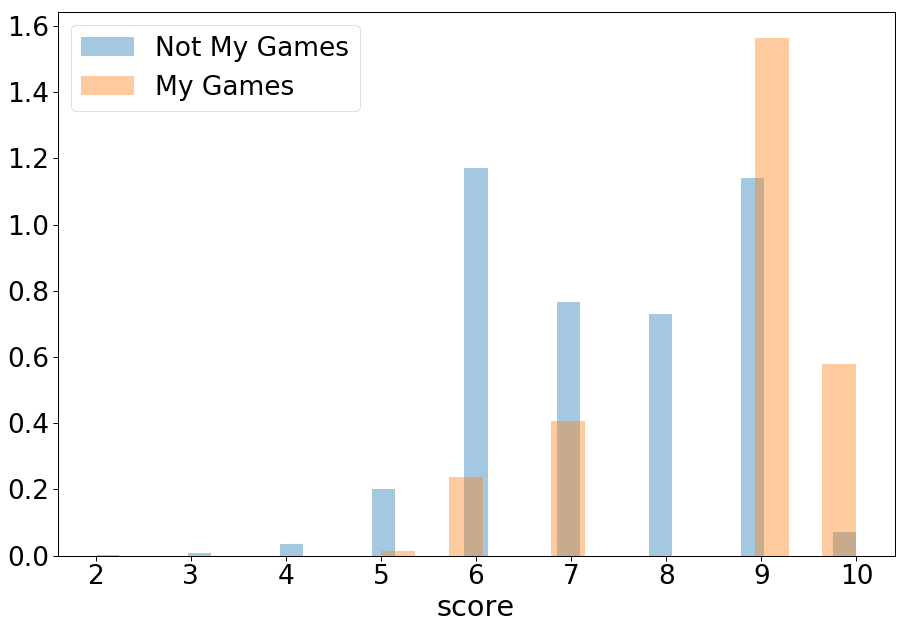

In [161]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_my_games['score'], norm_hist=True, kde=False, label='Not My Games', ax=ax)
sns.distplot(my_games_info['score'], norm_hist=True, kde=False, label='My Games', ax=ax)
plt.legend()
plt.show()

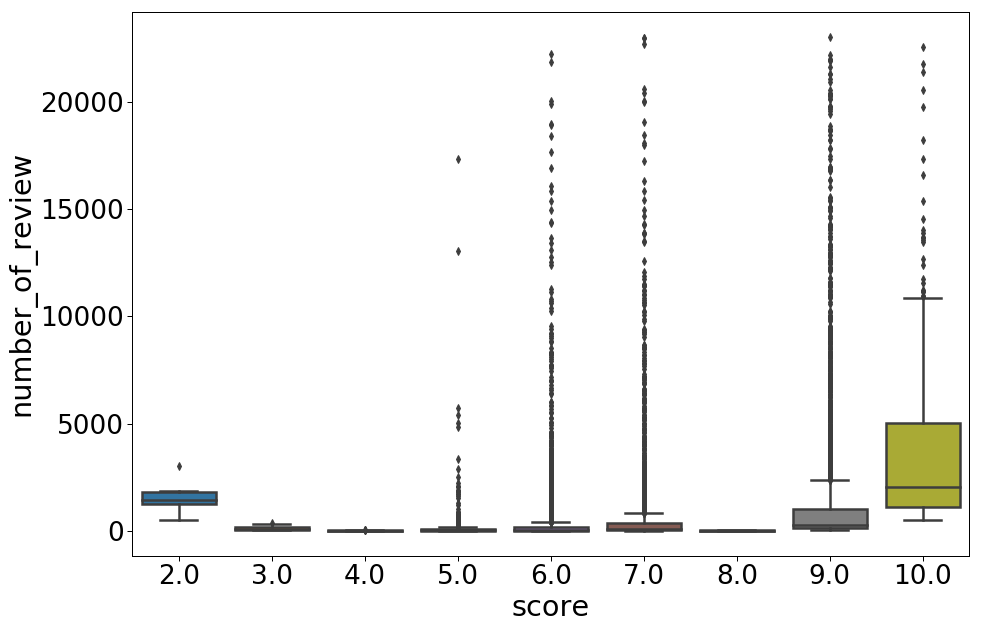

In [74]:
no_out = df[df['number_of_review'] < 23045]
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="score", y = 'number_of_review', data=no_out, linewidth=2.5)

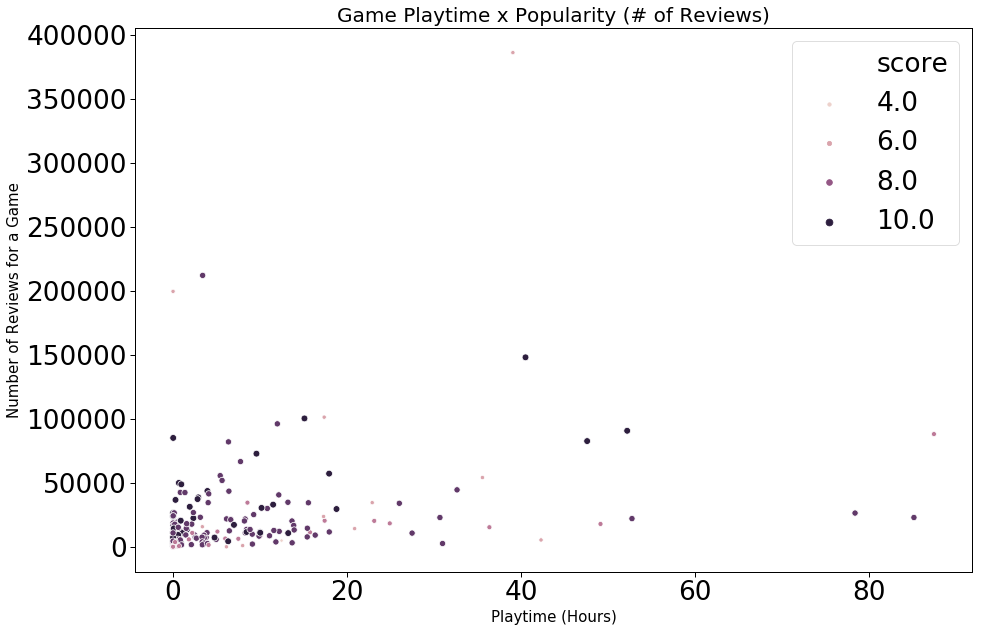

In [75]:
# Removed outliers.  'Counter-Strike' is a free-to-play game with > 2 million reviews
df_csno = my_games_info[~my_games_info.game_title.str.contains('Counter-Strike: Global Offensive')]
df_csno = df_csno[df_csno['playtime_forever'] <= 100]

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x="playtime_forever", y="number_of_review", hue="score", 
                     size= 'score', data=df_csno)
plt.title('Game Playtime x Popularity (# of Reviews)', size = 20)
plt.xlabel('Playtime (Hours)', size=15)
plt.ylabel('Number of Reviews for a Game', size=15)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


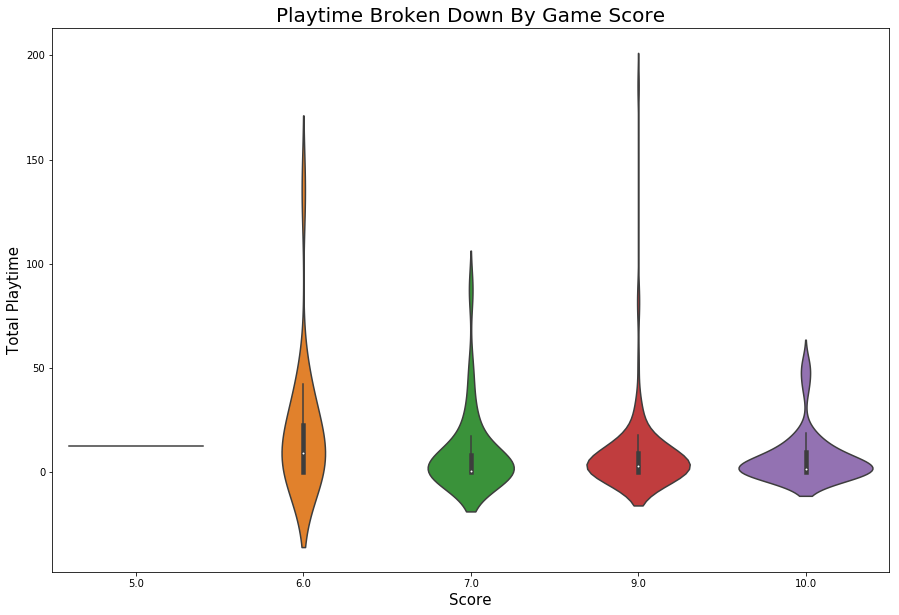

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="score", y="playtime_forever", data=my_games_info)
plt.title('Playtime Broken Down By Game Score', size = 20)
plt.xlabel('Score', size=15)
plt.ylabel('Total Playtime', size=15)
plt.show()

## Building the Recommender ##
### Evaluation ###
Evaluating a recommender is tough.  Since people's choices and preferences are subjective, there aren't a lot of metrics that can tell you whether or not your enginge performed well beyond looking at it and thinking that it did a goog job.  To try and combat this a bit, I built 3 different versions of the engine, one run by steam tags, another by descriptions, and a hybrid of the two. Then within each of those groups I split out the engine to have 1 that selects games you already own and recommends them to you, and another that looks at all the games you don't own.
### Tags Vs. Descriptions ###
For building the actual recommender system, I had originally decided that I would use Steam tags that are associated with every game.  However, because it was easy enough to collect, I also had descriptions for every game.  So I decided to test the recommendation system with three different setups.  The first being description only, the second being tags only, and the third being a hybrid of both.

#### Parsing Game Descriptions ####
For building the recommender with text descriptions, I used sklearn's term frequency inverse document frequency module to break the descriptions down to components and assign specific weights to 

In [126]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [237]:
cv_desc = df[['appid', 'game_title', 'tags', 'description']]

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

cv_desc['stemmed'] = cv_desc.description.apply(lambda x: stemmer.stem(x))
cv_desc['tokens'] = cv_desc.stemmed.apply(lambda x: tokenizer.tokenize(x))
cv_desc['lemmed'] = cv_desc.tokens.apply(lemmatize_text)
cv_desc['stopped'] = cv_desc.lemmed.apply(lambda x: [item for item in x if item not in stop_words])
cv_desc['desc']=cv_desc['stopped'].apply(lambda x: ', '.join(map(str, x)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [248]:
#tfidf_vec_desc = df[['appid', 'game_title', 'tags', 'description']]

cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2))
cv_matrix = cv.fit_transform(cv_desc['desc'])
# Linear kernel provides better results for descriptions
cosine_similarities = linear_kernel(cv_matrix, cv_matrix)

results_desc = {}

for idx, row in cv_desc.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], cv_desc['appid'][i]) for i in similar_indices]
    results_desc[row['appid']] = similar_items[1:]
    
print('done!')

done!


In [249]:
def recommend(game, num):
    app_id = cv_desc.loc[cv_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_desc[app_id]

    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
0,3.00000,Prince of Persia,0.00000
1,3.00000,Prince of Persia: The Sands of Time,0.00000
2,2.00000,"Star Wars: Battlefront 2 (Classic, 2005)",0.13333
4,2.00000,Lara Croft and the Guardian of Light,0.00000
5,2.00000,LIMBO,0.00000


In [262]:
def recommend(game, num):
    app_id = cv_desc.loc[cv_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_desc[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    #my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 10)

Fine, here are 10 games you could buy that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,steam_url
0,9.00000,Assassin’s Creed Liberation HD,https://store.steampowered.com/app/260210/Assassins_Creed_Liberation_HD/?snr...
1,9.00000,Assassin’s Creed Rogue,https://store.steampowered.com/app/311560/Assassins_Creed_Rogue/?snr=1_7_7_2...
2,8.00000,Xenia,https://store.steampowered.com/app/687310/Xenia/?snr=1_7_7_230_150_546
3,8.00000,Masochisia,https://store.steampowered.com/app/396310/Masochisia/?snr=1_7_7_230_150_142
4,8.00000,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assassins_Creed_Origins/?snr=1_7_7...
5,8.00000,FATE: The Cursed King,https://store.steampowered.com/app/303690/FATE_The_Cursed_King/?snr=1_7_7_23...
6,7.00000,The Pirate's Fate,https://store.steampowered.com/app/553480/The_Pirates_Fate/?snr=1_7_7_230_15...
7,7.00000,Living Legends: The Frozen Fear Collection,https://store.steampowered.com/app/398620/Living_Legends_The_Frozen_Fear_Col...
8,6.00000,Assassin's Creed: Director's Cut Edition,https://store.steampowered.com/app/15100/Assassins_Creed_Directors_Cut_Editi...
9,6.00000,Fate Hunters,https://store.steampowered.com/app/920680/Fate_Hunters/?snr=1_7_7_230_150_155


#### Using Steam Tags to Build the Engine ####
Every game on steam has a set of user-defined tags that it gets associated to.  Here, I used these tags to compute the similarity betwe

In [243]:
count_vec_tags = df[['appid', 'game_title', 'tags', 'description']]
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
count_matrix = vectorizer.fit_transform(count_vec_tags['tags'])
cosine_similarities = cosine_similarity(count_matrix, count_matrix)
results_tags = {}

for idx, row in count_vec_tags.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], count_vec_tags['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags[row['appid']] = similar_items[1:]
    
print('Done!')

Done!


In [244]:
def recommend(game, num):
    app_id = count_vec_tags.loc[count_vec_tags['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
10,0.55762,Mass Effect 2,0.58333
12,0.54595,Prince of Persia,0.00000
23,0.51320,Fallout 3: Game of the Year Edition,0.00000
26,0.50918,Prince of Persia: Warrior Within,0.10000
28,0.49892,Quantum Break,0.00000


In [246]:
def recommend(game, num):
    app_id = count_vec_tags.loc[count_vec_tags['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 10)

Fine, here are 10 games you could buy that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,steam_url
0,0.75485,Assassin's Creed Syndicate,https://store.steampowered.com/app/368500/Assassins_Creed_Syndicate/?snr=1_7...
1,0.75485,Dishonored: Death of the Outsider,https://store.steampowered.com/app/614570/Dishonored_Death_of_the_Outsider/?...
2,0.71443,Vampyr,https://store.steampowered.com/app/427290/Vampyr/?snr=1_7_7_230_150_8
4,0.70273,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assassins_Creed_Origins/?snr=1_7_7...
3,0.70273,Assassin's Creed Revelations,https://store.steampowered.com/app/201870/Assassins_Creed_Revelations/?snr=1...
5,0.69282,Assassin's Creed Freedom Cry,https://store.steampowered.com/app/277590/Assassins_Creed_Freedom_Cry/?snr=1...
6,0.67900,Assassin’s Creed Brotherhood,https://store.steampowered.com/app/48190/Assassins_Creed_Brotherhood/?snr=1_...
7,0.67003,The Technomancer,https://store.steampowered.com/app/338390/The_Technomancer/?snr=1_7_7_230_15...
8,0.66759,Assassin's Creed: Director's Cut Edition,https://store.steampowered.com/app/15100/Assassins_Creed_Directors_Cut_Editi...
9,0.66667,Styx: Master of Shadows,https://store.steampowered.com/app/242640/Styx_Master_of_Shadows/?snr=1_7_7_...


#### Hybrid Descriptions & Steam Tags ####
Now let's mash the two together and see what we get.

In [227]:
cv_hybrid = df[['appid', 'game_title', 'tags', 'description']]

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

cv_hybrid['stemmed'] = cv_hybrid.description.apply(lambda x: stemmer.stem(x))
cv_hybrid['tokens'] = cv_hybrid.stemmed.apply(lambda x: tokenizer.tokenize(x))
cv_hybrid['lemmed'] = cv_hybrid.tokens.apply(lemmatize_text)
cv_hybrid['stopped'] = cv_hybrid.lemmed.apply(lambda x: [item for item in x if item not in stop_words])
cv_hybrid['desc']=cv_hybrid['stopped'].apply(lambda x: ', '.join(map(str, x)))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [256]:
cv_hybrid['tag_desc'] = cv_hybrid[['tags', 'desc']].apply(lambda x: ' '.join(x), axis=1)
cv = CountVectorizer(analyzer='word', lowercase=True)
cv_hybrid_matrix = cv.fit_transform(cv_hybrid['tag_desc'])
cosine_similarities = cosine_similarity(cv_hybrid_matrix, cv_hybrid_matrix)

results_tags_desc = {}

for idx, row in cv_hybrid.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], cv_hybrid['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags_desc[row['appid']] = similar_items[1:]
    
print('done!')



done!


In [261]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
15,0.31449,Mass Effect 2,0.58333
16,0.31334,Prince of Persia,0.00000
18,0.30551,Fallout: New Vegas,0.66667
28,0.29155,Fallout 3: Game of the Year Edition,0.00000
34,0.28167,Quantum Break,0.00000
35,0.28037,Bastion,0.88333
38,0.27406,Batman: Arkham City - Game of the Year Edition,0.00000
41,0.27196,Darksiders Warmastered Edition,0.00000
47,0.26312,"Star Wars: Battlefront 2 (Classic, 2005)",0.13333
49,0.26128,Prince of Persia: Warrior Within,0.10000


In [260]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 10)

Fine, here are 10 games you could buy that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,steam_url
0,0.50869,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assassins_Creed_Origins/?snr=1_7_7...
1,0.48507,Assassin’s Creed Brotherhood,https://store.steampowered.com/app/48190/Assassins_Creed_Brotherhood/?snr=1_...
2,0.48177,Assassin's Creed Freedom Cry,https://store.steampowered.com/app/277590/Assassins_Creed_Freedom_Cry/?snr=1...
3,0.46957,Assassin's Creed Syndicate,https://store.steampowered.com/app/368500/Assassins_Creed_Syndicate/?snr=1_7...
4,0.46381,Assassin's Creed Revelations,https://store.steampowered.com/app/201870/Assassins_Creed_Revelations/?snr=1...
5,0.45873,Dishonored: Death of the Outsider,https://store.steampowered.com/app/614570/Dishonored_Death_of_the_Outsider/?...
6,0.43464,Assassin’s Creed Liberation HD,https://store.steampowered.com/app/260210/Assassins_Creed_Liberation_HD/?snr...
7,0.42960,Assassin's Creed Unity,https://store.steampowered.com/app/289650/Assassins_Creed_Unity/?snr=1_7_7_2...
8,0.42212,Assassin's Creed: Director's Cut Edition,https://store.steampowered.com/app/15100/Assassins_Creed_Directors_Cut_Editi...
9,0.42000,Assassin's Creed 2 Deluxe Edition,https://store.steampowered.com/app/33230/Assassins_Creed_2_Deluxe_Edition/?s...


Hybrid certainly looks good.  Let's test it out on some others just to see.

In [263]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Rocket League", 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to Rocket League.


,sim_score,game_title,playtime_forever
0,0.54600,Trine 2: Complete Story,0.00000
1,0.53579,Monaco: What's Yours Is Mine,0.00000
2,0.51579,Lethal League,0.00000
3,0.51344,Trine Enchanted Edition,0.00000
4,0.50526,Awesomenauts - the 2D moba,0.01667
6,0.48136,Mount Your Friends,0.23333
7,0.46935,Castle Crashers,0.28333
14,0.40659,Lara Croft and the Guardian of Light,0.00000
19,0.36624,Guacamelee! Gold Edition,0.00000
23,0.35065,Octodad: Dadliest Catch,0.83333


In [264]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Rocket League", 10)

Fine, here are 10 games you could buy that are similar to Rocket League.


,sim_score,game_title,steam_url
0,0.60449,Move or Die,https://store.steampowered.com/app/323850/Move_or_Die/?snr=1_7_7_230_150_16
1,0.60049,Robot Roller-Derby Disco Dodgeball,https://store.steampowered.com/app/270450/Robot_RollerDerby_Disco_Dodgeball/...
2,0.59286,Sonic & All-Stars Racing Transformed Collection,https://store.steampowered.com/app/212480/Sonic__AllStars_Racing_Transformed...
3,0.58920,Bloody Trapland,https://store.steampowered.com/app/257750/Bloody_Trapland/?snr=1_7_7_230_150_74
4,0.58840,Stick Fight: The Game,https://store.steampowered.com/app/674940/Stick_Fight_The_Game/?snr=1_7_7_23...
5,0.57716,ROCKETSROCKETSROCKETS,https://store.steampowered.com/app/289760/ROCKETSROCKETSROCKETS/?snr=1_7_7_2...
6,0.57639,Overcooked,https://store.steampowered.com/app/448510/Overcooked/?snr=1_7_7_230_150_14
7,0.55641,Overcooked! 2,https://store.steampowered.com/app/728880/Overcooked_2/?snr=1_7_7_230_150_2
8,0.55641,BattleBlock Theater,https://store.steampowered.com/app/238460/BattleBlock_Theater/?snr=1_7_7_230...
9,0.55464,Zero-G,https://store.steampowered.com/app/567890/ZeroG/?snr=1_7_7_230_150_216


In [265]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("PLAYERUNKNOWN'S BATTLEGROUNDS", 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to PLAYERUNKNOWN'S BATTLEGROUNDS.


,sim_score,game_title,playtime_forever
0,0.56819,H1Z1,0.00000
3,0.49035,Lead and Gold: Gangs of the Wild West,0.68333
4,0.48059,"Star Wars: Battlefront 2 (Classic, 2005)",0.13333
12,0.44866,"Warhammer 40,000: Space Marine",0.30000
13,0.43961,Red Faction: Armageddon,0.00000
17,0.41660,Red Orchestra 2: Heroes of Stalingrad with Rising Storm,0.20000
22,0.40326,Day of Defeat: Source,0.15000
33,0.34839,Lara Croft and the Guardian of Light,0.00000
34,0.34124,Alan Wake's American Nightmare,0.00000
37,0.33411,Fallout: New Vegas,0.66667


In [266]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("PLAYERUNKNOWN'S BATTLEGROUNDS", 10)

Fine, here are 10 games you could buy that are similar to PLAYERUNKNOWN'S BATTLEGROUNDS.


,sim_score,game_title,steam_url
0,0.66430,Realm Royale,https://store.steampowered.com/app/813820/Realm_Royale/?snr=1_7_7_230_150_31
1,0.66205,Ring of Elysium,https://store.steampowered.com/app/755790/Ring_of_Elysium/?snr=1_7_7_230_150_9
2,0.63681,Primal Carnage: Extinction,https://store.steampowered.com/app/321360/Primal_Carnage_Extinction/?snr=1_7...
3,0.63602,Pixel Royale,https://store.steampowered.com/app/931250/Pixel_Royale/?snr=1_7_7_230_150_934
4,0.62311,Holdfast: Nations At War,https://store.steampowered.com/app/589290/Holdfast_Nations_At_War/?snr=1_7_7...
5,0.62189,Freefall Tournament,https://store.steampowered.com/app/849940/Freefall_Tournament/?snr=1_7_7_230...
6,0.61849,Until None Remain: Battle Royale PC Edition,https://store.steampowered.com/app/697010/Until_None_Remain_Battle_Royale_PC...
7,0.61539,Until None Remain: Battle Royale VR,https://store.steampowered.com/app/697020/Until_None_Remain_Battle_Royale_VR...
8,0.61049,ORION: Prelude,https://store.steampowered.com/app/104900/ORION_Prelude/?snr=1_7_7_230_150_204
9,0.60861,DESOLATE,https://store.steampowered.com/app/671510/DESOLATE/?snr=1_7_7_230_150_38


## I Declare Hybrid The Winner ##
While all three of the models performed well and gave me results that I would consider well within the normal range of what I might consider to be a good recommendation, I think the hybrid system does slightly better than the tag-only system, so it gets the edge.  The fact that it was able to see that I fed it an Assassin's Creed game and recommend me literally EVERY single one that I don't own (on steam) is commendable.  It also performed well when I fed it a party/competative game (Rocket League) and a large scale shooter (PlayerUnknown's Battlegrounds). 

<br>
The tag-only system also did well and, one could, say that it is actually a better performer cause it give some variety, but I don't want variety I want games that I'm going to like!  Description-only comes in last, not surprising considering that most game descriptions on the steam store can be fairly generic and short.